In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymysql

In [124]:
# Functions

## given two curve a, b, then return the inversection point of two curves
def FindTheBuyPoint(a, b):
    buyPoint = np.argwhere(np.diff(np.sign(a - b)) > 0).reshape(-1) + 0
    return buyPoint

def FindTheSellPoint(a, b):
    sellPoint = np.argwhere(np.diff(np.sign(a - b)) < 0).reshape(-1) + 0
    return sellPoint

def GetDataFromDB(ip, userName, psw, tableName, sql):
    try:
        db = pymysql.connect(ip, userName, psw, tableName)
    except:
        print ("Error: unable to connect to DB")
        
    #create a cursor
    cursor = db.cursor()

    try:
        cursor.execute(sql)
        results = cursor.fetchall()
    except:
        print ("Error: unable to fetch data from DB")
    
    db.close()
    
    return results

def SMA(data, period):
    if (type(data) == pd.core.series.Series):
        return data.rolling(window = period).mean()
    else:
        print ("Error: Wrong input, SMA(pandas.core.series.Series, integer)")
        
def EMA(data, period):
    if (type(data) == pd.core.series.Series):
        return data.ewm(span = period, adjust = False).mean()
    else:
        print ("Error: Wrong input, EMA(pandas.core.series.Series, integer)")
        
def RSI(data, period):
    if (type(data) == pd.core.series.Series):
        delta = data.diff()
        up, down = delta.copy(), delta.copy()

        up[up < 0] = 0
        down[down > 0] = 0
        down = abs(down)

        Up = SMA(up, period)

        Up = rUp.fillna(0)
        for i in range(period + 1,len(rUp)):
            Up[i] = (Up[i - 1] * (period - 1) + up[i]) / period

        Down = SMA(down, period)
        Down = rDown.fillna(0)
        for i in range(period + 1,len(rUp)):
            Down[i] = (Down[i - 1] * (period - 1) + down[i]) / period


        rsi = 100 * (Up / (Up + Down))
        rsi = rsi.fillna(0)
        return rsi
    else:
        print ("Error: Wrong input, RSI(pandas.core.series.Series, integer)")
        
def MACD(data, period = []):
    if (type(data) == pd.core.frame.DataFrame and len(period) == 3):   
        di = (data['High'] + data['Low'] + 2.0 * data['Close']) / 4.0
        ema12 = SMA(di, period[0])
        ema12 = ema12.fillna(0)
        for i in range(period[0] + 1, len(ema12)):
            ema12[i] = (ema12[i - 1] * (period[0] - 1) + di[i] * 2.0) / (period[0] + 1)
    
        ema26 = SMA(di, period[1])
        ema26 = ema26.fillna(0)
        for i in range(period[1] + 1, len(ema26)):
            ema26[i] = (ema26[i - 1] * (period[1] - 1) + di[i] * 2.0) / (period[1] + 1)
    
        dif = ema12 - ema26

        dem = SMA(dif, period[2])
        dem = dem.fillna(0)
        for i in range(period[2] + 1, len(dem)):
            dem[i] = (dem[i - 1] * (period[2] - 1) + dif[i] * 2.0) / (period[2] + 1)
        return dif, dem
    else:
        if(type(data) == pd.core.frame.DataFrame):
            print ("Error: Wrong input, MACD(pandas.core.frame.DataFrame, list of integer)")
        elif(len(period) == 3):
            print ("Error: number of content in list do not equal to 3")

In [50]:
# define a class - indicators, which contains all indicators that calculate by the data
class Indicators:
    data = []
    EMA = {}
    SMA = {}
    RSI = []
    KD = {
        'k': [],
        'd': []
    }
    MACD = {
        'dif': [],
        'dem': []
    }
    
    def __init__(self, inputData):
        self.data = inputData
        self.SMA = self.setSMA([5, 20, 100])
    
    def setSMA(self, periods = []):
        smaResults = []
        for i in range(len(periods)):
            if (type(periods[i]) != int):
                print ("Error: inputData is not a list of integer")
                return
            else:
                smaResults.append(SMA(self.data, periods[i]))
                
        return dict((("sma" + str(i)), smaResults[i]) for i in range(len(smaResults)))
    
    def getSMA(self):
        return self.SMA

In [51]:
#get the close price from DB

try:
    sql = "SELECT LAST, DATE FROM btc_usd ORDER BY DATE"
    results = GetDataFromDB("140.118.126.136", "123", "1234567890", "test", sql)
    
    Dates = []
    ClosePrices = []
    for i in range(len(results)):
        Dates.append(results[i][1])
        ClosePrices.append(results[i][0])
    
    closePriceData = {
        'Date' : Dates,
        'Close' : ClosePrices
    }

    dfs_close = pd.DataFrame(closePriceData)

except:
    print ("Error: unable to fetch data from DB")

In [52]:
# sma
sma5_close = SMA(dfs_close['Close'], 5)
sma20_close = SMA(dfs_close['Close'], 20)
sma100_close = SMA(dfs_close['Close'], 100)

indicators = Indicators(dfs_close['Close'])

In [53]:
# ema
ema12_close = EMA(dfs_close['Close'], 12)
ema26_close = EMA(dfs_close['Close'], 26)

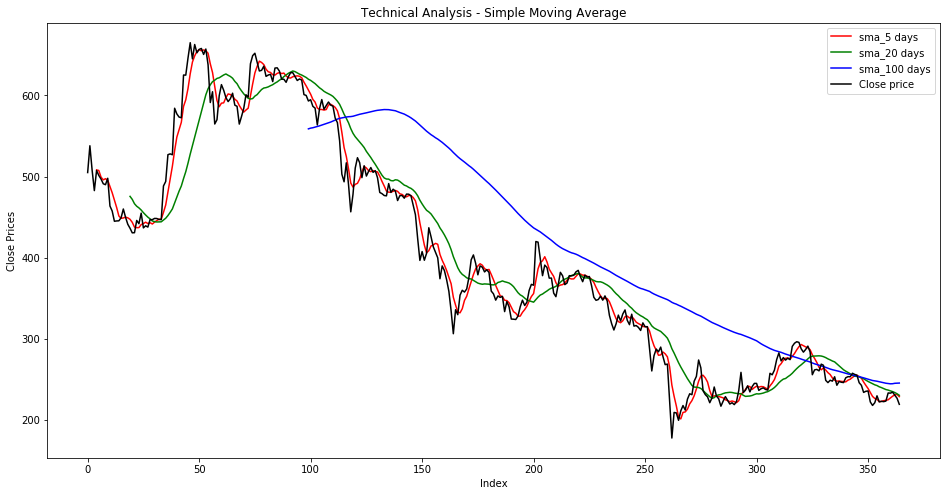

In [54]:
# Draw SMA curve
totalDate = 365
plt.figure(figsize = (16, 8))

x = [i for i in range(len(dfs_close.head(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

## draw sma5
sma5c = [sma5_close[i] for i in range(len(sma5_close.head(totalDate)))]
plt.plot(x, sma5c, 'r', label = 'sma_5 days')

## draw sma20
sma20c = [sma20_close[i] for i in range(len(sma20_close.head(totalDate)))]
plt.plot(x, sma20c, 'g', label = 'sma_20 days')

## draw sma100
sma100c = [sma100_close[i] for i in range(len(sma100_close.head(totalDate)))]
plt.plot(x, sma100c, 'b', label = 'sma_100 days')

## draw all close prices
plt.plot(x, dfs_close['Close'].head(totalDate), label = 'Close price', color = 'k')

## draw the intersection points of three curves
# FindTheIntersection(sma5c, sma20c)

#p#icture setting
plt.xlabel("Index")
plt.ylabel("Close Prices")
plt.title("Technical Analysis - Simple Moving Average")
plt.legend(loc = 'upper right')

##show picture
plt.show()

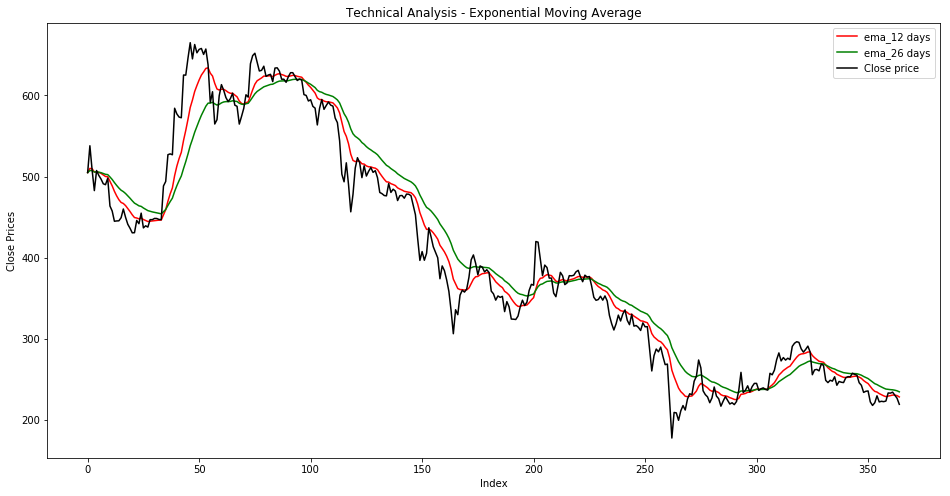

In [55]:
# Draw EMA curve
totalDate = 365
plt.figure(figsize = (16, 8))

x = [i for i in range(len(dfs_close.head(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

##draw ema12
ema12c = [ema12_close[i] for i in range(len(ema12_close.head(totalDate)))]
plt.plot(x, ema12c, 'r', label = 'ema_12 days')

##draw ema26
ema26c = [ema26_close[i] for i in range(len(ema26_close.head(totalDate)))]
plt.plot(x, ema26c, 'g', label = 'ema_26 days')

##draw all close prices
plt.plot(x, dfs_close['Close'].head(totalDate), label = 'Close price', color = 'k')

#p#icture setting
plt.xlabel("Index")
plt.ylabel("Close Prices")
plt.title("Technical Analysis - Exponential Moving Average")
plt.legend(loc = 'upper right')

##show picture
plt.show()

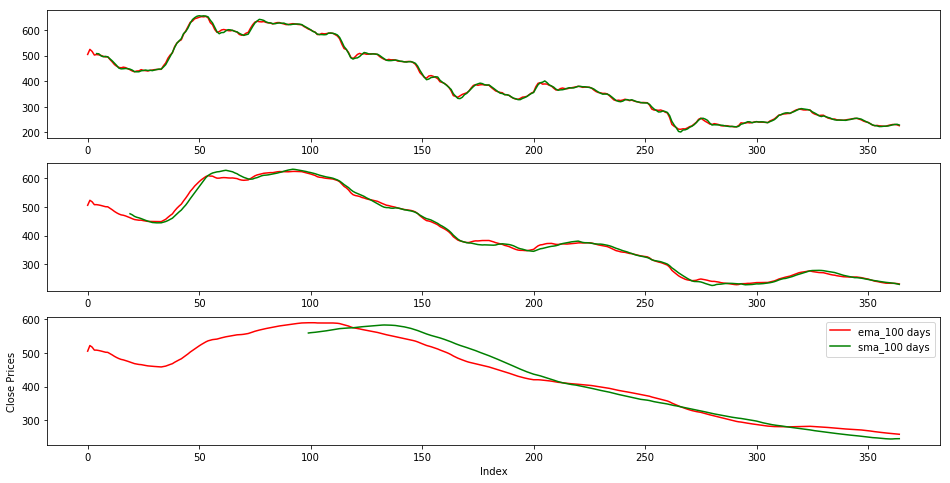

In [56]:
##compare EMA & SMA

# Draw EMA curve
totalDate = 365
plt.figure(figsize = (16, 8))
plt.subplot(3,1,1)
x = [i for i in range(len(dfs_close.head(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

##draw ema5
ema5_close = dfs_close['Close'].ewm(span = 5).mean()
ema5c = [ema5_close[i] for i in range(len(ema5_close.head(totalDate)))]
plt.plot(x, ema5c, 'r', label = 'ema_5 days')

##draw sma5
plt.plot(x, sma5c, 'g', label = 'sma_5 days')

plt.subplot(3,1,2)

##draw ema20
ema20_close = dfs_close['Close'].ewm(span = 20).mean()
ema20c = [ema20_close[i] for i in range(len(ema20_close.head(totalDate)))]
plt.plot(x, ema20c, 'r', label = 'ema_20 days')

##draw sma20
plt.plot(x, sma20c, 'g', label = 'sma_20 days')

plt.subplot(3,1,3)

##draw ema100
ema100_close = dfs_close['Close'].ewm(span = 100).mean()
ema100c = [ema100_close[i] for i in range(len(ema100_close.head(totalDate)))]
plt.plot(x, ema100c, 'r', label = 'ema_100 days')

##draw sma100
plt.plot(x, sma100c, 'g', label = 'sma_100 days')

#picture setting
plt.xlabel("Index")
plt.ylabel("Close Prices")
plt.legend(loc = 'upper right')

##show picture
plt.show()

In [57]:
# get the High & Low Price from DB

#try to search all close prices in DB, and change the type to list
sql = "SELECT HIGH, LOW, DATE FROM btc_usd ORDER BY DATE"

try:
    results = GetDataFromDB("140.118.126.136", "123", "1234567890", "test", sql)
    
    Dates = []
    HighPrices = []
    LowPrices = []
    for i in range(len(results)):
        Dates.append(results[i][2])
        HighPrices.append(results[i][0])
        LowPrices.append(results[i][1])
    
    PriceData = {
        'Date' : Dates,
        'High' : HighPrices,
        'Low' : LowPrices
    }
except:
    print ("Error: unable to fetch data from DB")
    
dfs_HL = pd.DataFrame(PriceData)

In [58]:
# KD
dfs_HL['RSV'] = 100 * (( dfs_close['Close'] - dfs_HL['Low'].rolling(window = 9).min()) / (dfs_HL['High'].rolling(window = 9).max() - dfs_HL['Low'].rolling(window = 9).min()))

dfs_HL['RSV'].fillna(method = 'bfill', inplace = True)

data = {
    'K9':[17],
    'D9':[39]
}

#calculate everyday's KD
for i in range(1, len(dfs_HL.index)):
    K9_value = (1.0/3.0) * dfs_HL['RSV'][i] + (2.0 / 3.0) * data['K9'][i - 1]
    data['K9'].append(K9_value)
    D9_value = (2.0/3.0) * data['D9'][i - 1] + (1.0 / 3.0) * data['K9'][i]
    data['D9'].append(D9_value)
    
dfs_KD = pd.DataFrame(data)

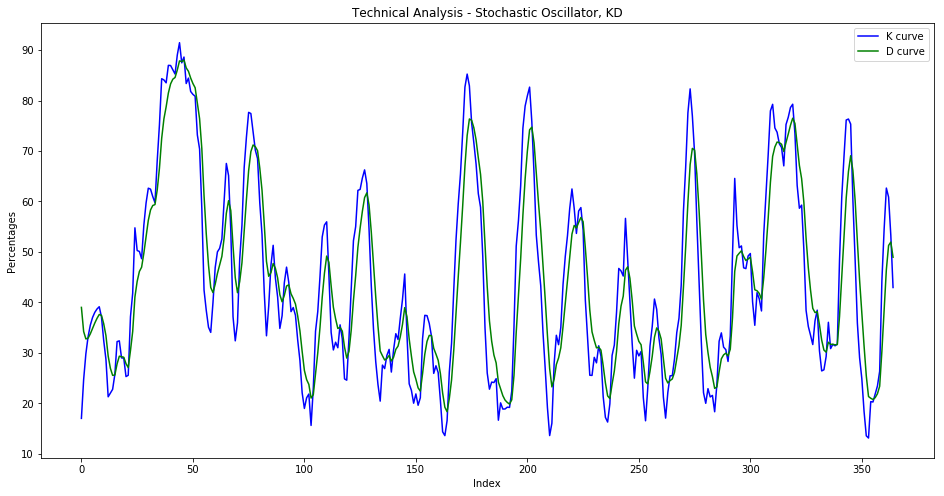

In [59]:
# Draw the KD Curve
totalDate = 365
plt.figure(figsize = (16, 8))

x = [i for i in range(len(dfs_close.head(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

## Draw K curve
Kc = [dfs_KD['K9'][i] for i in range(len(dfs_KD['K9'].head(totalDate)))]
plt.plot(x, Kc, 'b', label = 'K curve')

## Draw D curve
Dc = [dfs_KD['D9'][i] for i in range(len(dfs_KD['D9'].head(totalDate)))]
plt.plot(x, Dc, 'G', label = 'D curve')

##draw all intersection point of two curves
#buyPoint = FindTheBuyPoint(Dc, Kc)
#sellPoint = FindTheSellPoint(Dc, Kc)

#p#icture setting
plt.xlabel("Index")
plt.ylabel("Percentages")
plt.title("Technical Analysis - Stochastic Oscillator, KD")
plt.legend(loc = 'upper right')

##show picture
plt.show()

In [103]:
# RSI
stockData_1101 = pd.read_csv(r"C:\Users\Mike\Desktop\1101.TW.csv", converters={"Open":float, "High":float, "Low":float, "Close":float})
result = pd.DataFrame(stockData_1101)

period = 14

rsi = RSI(result['Close'], period)

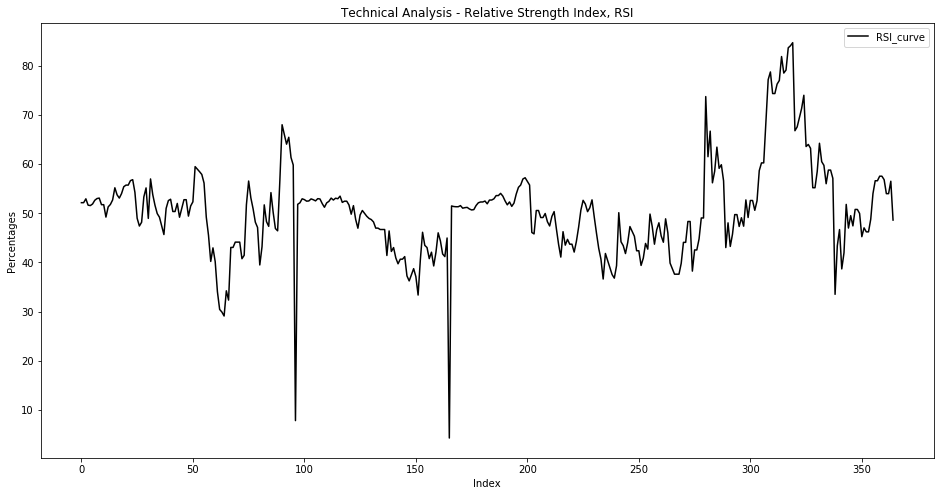

In [106]:
# Draw RSI curve
totalDate = 365
plt.figure(figsize = (16, 8))

x = [i for i in range(len(dfs_close.tail(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

## Draw rsi curve
rsic = plt.plot(x, rsi.tail(totalDate), 'k', label = 'RSI_curve')

#p#icture setting
plt.xlabel("Index")
plt.ylabel("Percentages")
plt.title("Technical Analysis - Relative Strength Index, RSI")
plt.legend(loc = 'upper right')

##show picture
plt.show()

In [129]:
# MACD
stockData_1101 = pd.read_csv(r"C:\Users\Mike\Desktop\1101.TW.csv", converters={"Open":float, "High":float, "Low":float, "Close":float})
result = pd.DataFrame(stockData_1101)

dif, dem = MACD(result, [12,26,9])
# 小數點下兩位正確

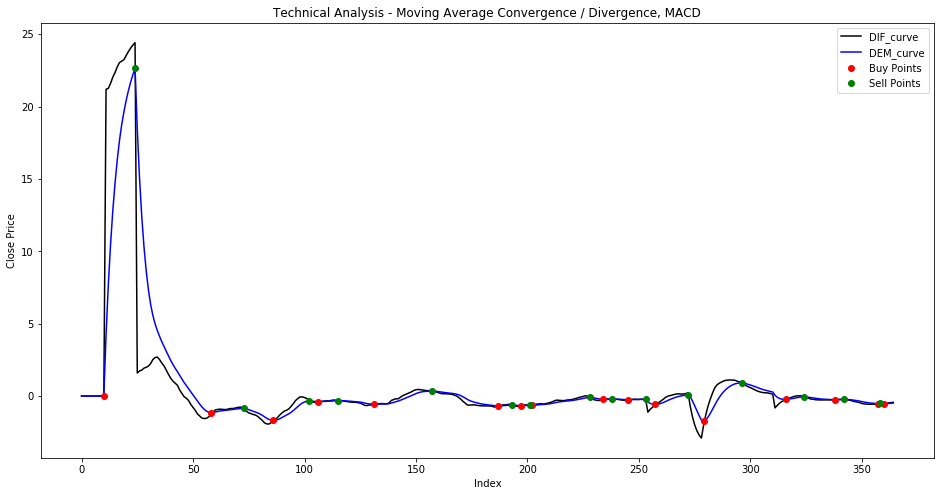

In [131]:
# draw MACD Curve
totalDate = 365
plt.figure(figsize = (16, 8))

x = [i for i in range(len(dfs_close.head(totalDate)))]
#x = list(dfs['Date'].head(totalDate))

## Draw DIF curve
difc = plt.plot(x, dif.head(totalDate), 'k', label = 'DIF_curve')

## Draw DEM curve
demc = plt.plot(x, dem.head(totalDate), 'b', label = 'DEM_curve')

## Draw the intersection points of two curves
buyPoint = FindTheBuyPoint(dif.head(totalDate), dem.head(totalDate))
sellPoint = FindTheSellPoint(dif.head(totalDate), dem.head(totalDate))
buyPoints = [buyPoint[i] for i in range(len(buyPoint))]
sellPoints = [sellPoint[i] for i in range(len(sellPoint))]

plt.plot(buyPoints, dem[buyPoints], "ro", label = "Buy Points")
plt.plot(sellPoints, dem[sellPoints], "go", label = "Sell Points")

#picture setting
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.title("Technical Analysis - Moving Average Convergence / Divergence, MACD")
plt.legend(loc = 'upper right')

##show picture
plt.show()